<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Background
</h2>

<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Import Libraries
</h2>

In [1]:
# load libraries

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Load Dataset || EDA Process
</h2>

In [2]:
# read data from CSV file into a DataFrame
raw_df = pd.read_csv('test3_data.csv')
raw_df.sample(2)

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
625951,625952,AMsySZbfiBvKX5tb0Q8otTTGX4N0,1505770789083832,View,Facebook,160x600,JoeFresh,Blue,0.760237
847975,847976,AMsySZYsf3bRaoMcx5acRvl7JVFk,1502655040036332,View,Amazon,728x90,Old Navy,Yellow,0.376210


In [3]:
# reduce the dataset to reduce computational burden

# initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=100000, random_state=1)

# perform the split
for train_index, test_index in sss.split(raw_df, raw_df['Action']):
    stratified_sample = raw_df.iloc[test_index]
raw_df = stratified_sample

In [4]:
print(raw_df['Action'].value_counts())

Action
View     99976
Click       24
Name: count, dtype: int64


In [5]:
# get a quick summary of the dataset
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 236820 to 638551
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       100000 non-null  int64  
 1   ID               100000 non-null  object 
 2   ActionTime       100000 non-null  int64  
 3   Action           100000 non-null  object 
 4   Website          100000 non-null  object 
 5   BannerSize       100000 non-null  object 
 6   Brand            100000 non-null  object 
 7   colour           100000 non-null  object 
 8   InteractionTime  100000 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 7.6+ MB


In [6]:
# view the distribution of data
raw_df.nunique()

Unnamed: 0         100000
ID                  56407
ActionTime         100000
Action                  2
Website                16
BannerSize             15
Brand                  10
colour                  7
InteractionTime     99999
dtype: int64

In [7]:
# remove unnecessary features
## 'ID' is removed for privacy and 'Unamed: 0' seems to be row index which is not required
raw_df = raw_df.drop(columns = ['Unnamed: 0', 'ID'])
raw_df.columns

Index(['ActionTime', 'Action', 'Website', 'BannerSize', 'Brand', 'colour',
       'InteractionTime'],
      dtype='object')

In [8]:
# seperate the target variable and the predictor
X_raw = raw_df.drop(columns=['Action'])
y = raw_df['Action']
print(f'X_raw shape: {X_raw.shape}, y shape: {y.shape}')

X_raw shape: (100000, 6), y shape: (100000,)


In [9]:
# encode the target variable to binary 1s & 0s
y = y.apply(lambda x : 1 if x == 'View' else 0)

In [10]:
# count each unique value in target variable
y.value_counts()

Action
1    99976
0       24
Name: count, dtype: int64

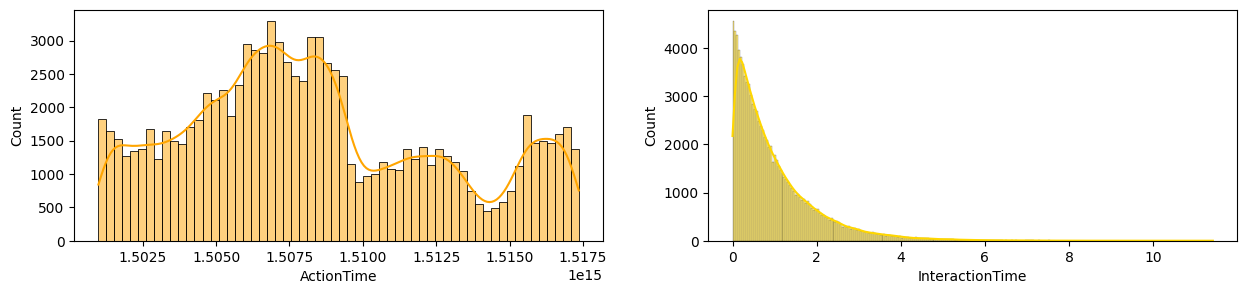

In [11]:
# check the distributions of ActionTime and InteractionTime

# create a figure and axis
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

# plot the distribution of each column using a histogram
sns.histplot(X_raw['ActionTime'], kde=True, color='orange', ax=ax[0])
sns.histplot(X_raw['InteractionTime'], kde=True, color='gold', ax=ax[1]);

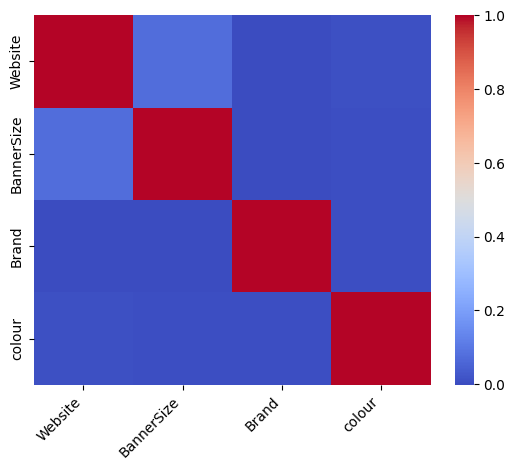

In [12]:
# compute correlation and plot heat map

# label encode the categorical columns
categorical_columns = ['Website', 'BannerSize', 'Brand', 'colour']
X_corr = X_raw[categorical_columns].apply(LabelEncoder().fit_transform)

# calculate correlation matrix
corr = X_corr.corr()

# create heatmap
ax = sns.heatmap(corr, cmap='coolwarm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Split || Missing Value Imputation
</h2>

In [13]:
# split the data to avoid data leak
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, random_state=1, stratify=y)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

X_train shape: (80000, 6), X_test shape: (20000, 6), y_train shape: (80000,), y_test shape: (20000,)


In [14]:
# fix the missing values in InteractionTime
imp = SimpleImputer(missing_values=pd.NA, strategy='median')
X_train['InteractionTime'] = imp.fit_transform(X_train[['InteractionTime']])
X_test['InteractionTime'] = imp.transform(X_test[['InteractionTime']])

In [15]:
# check for missing values in train set
X_train.isnull().sum()

ActionTime         0
Website            0
BannerSize         0
Brand              0
colour             0
InteractionTime    0
dtype: int64

In [16]:
# check for missing values in val set
X_test.isnull().sum()

ActionTime         0
Website            0
BannerSize         0
Brand              0
colour             0
InteractionTime    0
dtype: int64

<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Feature Transformation || Model Selection || Validation
</h2>

In [17]:
# feature transformation

# select categorical columns to encode
categorical_columns = ['Website', 'BannerSize', 'Brand', 'colour']

# initialize OHE
ohe = OneHotEncoder(handle_unknown='ignore')

# initialize ColumnTransformer to apply OHE to categorical columns only
col_xfmr = ColumnTransformer(transformers=[('cat', ohe, categorical_columns)], remainder='passthrough')

# fit and transform training and transform validation datasets
X_train_xfm = col_xfmr.fit_transform(X_train)
X_test_xfm = col_xfmr.transform(X_test)

# convert the resulting arrays back to df
feature_names = col_xfmr.get_feature_names_out()
X_train_xfm = pd.DataFrame(X_train_xfm.toarray(), columns=feature_names, index=X_train.index)
X_test_xfm = pd.DataFrame(X_test_xfm.toarray(), columns=feature_names, index=X_test.index)

In [18]:
# model validation pipeline

# initialize SMOTEENN to deal imbalance
smote_enn = SMOTEENN(random_state=1)

# initialize the scoring metric
scoring = make_scorer(f1_score)

# initialize the StratifiedKFold cross-validator
skf1 = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# Initialize the XGBoost classifier
xgb_class = xgb.XGBClassifier(random_state=1)

# create the pipeline
pipeline = make_pipeline(smote_enn, xgb_class)

# perform cross-validation
scores = cross_val_score(pipeline, X_train_xfm, y_train, cv=skf1, scoring=scoring)

# Print the cross-validation scores
print("Cross-validation F1 scores:", scores)
print("Mean F1 score:", np.mean(scores))

Cross-validation F1 scores: [0.99946847 0.99890505 0.99928073 0.99887373 0.99877976]
Mean F1 score: 0.9990615497673753


<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Pipeline || Prediction || Interpretation
</h2>

In [19]:
# ML Pipeline

# read the data
raw_df = pd.read_csv('test3_data.csv')


# initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=100000, random_state=1)
# perform the split
for train_index, test_index in sss.split(raw_df, raw_df['Action']):
    stratified_sample = raw_df.iloc[test_index]
raw_df = stratified_sample


# unselect features
raw_df = raw_df.drop(columns=['Unnamed: 0', 'ID'])

# separate the label and the features
X_raw = raw_df.drop(columns=['Action'])
y = raw_df['Action'].apply(lambda x : 1 if x == 'View' else 0) # select and encode label


# train test split
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, random_state=1, stratify=y)

# initialize imputation for missing values
imputer = SimpleImputer(missing_values=pd.NA, strategy='median')

# initialize OHE
encoder = OneHotEncoder(handle_unknown='ignore')

# column transformer for imputer and ohe
column_xfmr = ColumnTransformer(transformers=[('imp', imputer, ['InteractionTime']), 
                                           ('ohe', encoder, ['Website', 'BannerSize', 'Brand', 'colour'])
                                          ], remainder='passthrough')

# initialize SMOTEENN  to handle imbalance
smote = SMOTEENN(random_state=1)

# initialize xgb model
model = xgb.XGBClassifier(random_state=1)

# define the pipeline
pipeline = make_pipeline(column_xfmr, smote, model)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp',
                                                  SimpleImputer(missing_values=<NA>,
                                                                strategy='median'),
                                                  ['InteractionTime']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Website', 'BannerSize',
                                                   'Brand', 'colour'])])),
                ('smoteenn', SMOTEENN(random_state=1)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [20]:
# Prediction

# make predictions using the pipeline
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
FPR_xgb_test, TPR_xgb_test, _ = roc_curve(y_test, y_pred_proba)

# calculate scores
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

# print scores
print(f"Accuracy: {xgb_accuracy}, F1 Score: {xgb_f1}, AUC Score: {xgb_auc}")
xgb = [xgb_accuracy, xgb_f1, xgb_auc]

Accuracy: 0.99975, F1 Score: 0.9998749843730467, AUC Score: 0.5


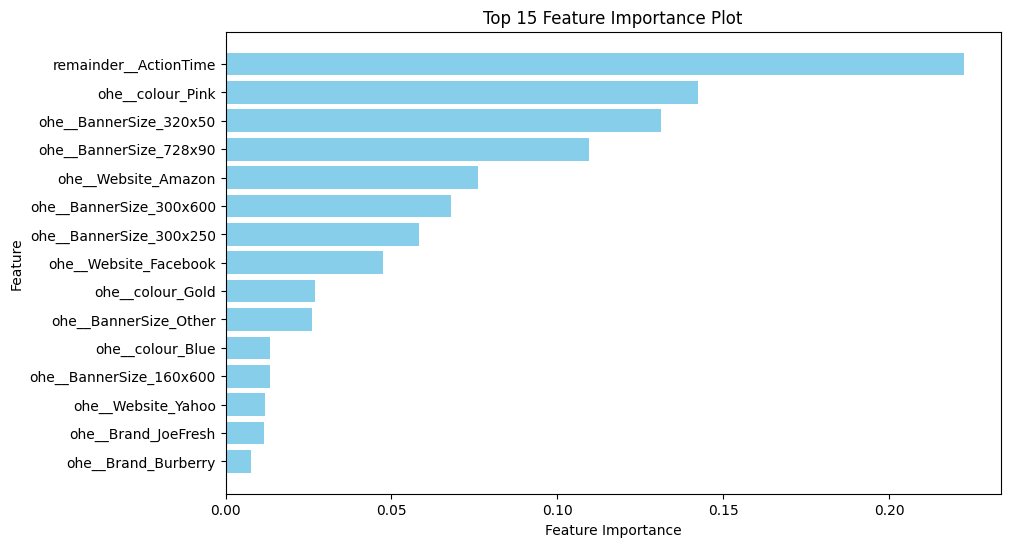

In [21]:
# interpretation using feature importance (top 15)

# extract feature importances from the trained XGBoost model
feature_importances = pipeline.named_steps['xgbclassifier'].feature_importances_

# get feature names from the column transformer
feature_names = pipeline.named_steps['columntransformer'].get_feature_names_out()

# zip feature names and their importances, then sort based on importances
feature_importance_sorted = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
sorted_features, sorted_importances = zip(*feature_importance_sorted)

# select only the first 15 features and their importances
top_features = sorted_features[:15]
top_importances = sorted_importances[:15]

# plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance Plot')
plt.gca().invert_yaxis()
plt.show()